In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import re

In [200]:
# Model Opening
model_path = 'NFW+SHEAR'
model_ver = 'NFW_POS_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'

In [201]:
# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

['------------------------------------------\n',
 'optimize ndim=13\n',
 'run 1: 1 lens models calculated\n',
 'chi^2 = 1.000000e+30  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 1.000000e+30 1.000000e+30 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   anfw    0.2613  5.000000e+11  2.078000e+01  2.078000e+01  1.000000e-01 -4.000000e+00  9.500000e+01  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  1.000000e-01  1.400000e+02  0.000000e+00  1.000000e-01 \n',
 'point  1.0000  2.075837e+01  2.123564e+01 \n',
 '------------------------------------------\n',
 '------------------------------------------\n',
 'optimize ndim=13\n',
 'run 2: 1790 lens models calculated\n',
 'chi^2 = 3.179114e-06  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000

In [202]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 46


['run 4: 96 lens models calculated\n',
 'chi^2 = 2.690996e-06  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 2.690996e-06 2.690996e-06 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   anfw    0.2613  2.093650e+11  2.081374e+01  2.076874e+01  7.602573e-02  4.057352e+01  9.493046e+01  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.079990e+01  2.059614e+01  3.929558e-02  1.515118e+02  0.000000e+00 -7.024158e-02 \n',
 'point  1.0000  2.082187e+01  2.079734e+01 \n',
 '------------------------------------------\n']

In [203]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
        


    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'anfw', '0.2613', '2.093650e+11', '2.081374e+01', '2.076874e+01', '7.602573e-02', '4.057352e+01', '9.493046e+01', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.079990e+01', '2.059614e+01', '3.929558e-02', '1.515118e+02', '0.000000e+00', '-7.024158e-02']
Number of lens profiles: 2


{'anfw': [209365000000.0,
  20.81374,
  20.76874,
  0.07602573,
  40.57352,
  94.93046,
  0.0],
 'pert': [1.0, 20.7999, 20.59614, 0.03929558, 151.5118, 0.0, -0.07024158]}

In [204]:
# Define the lens corresponding parameters (order preserved)
# POW
pow_params = ['$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']

# SIE
sie_params = ['σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# NFW
nfw_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']

# EIN
ein_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']

# SHEAR 
shear_params = ['$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']

# Sersic
sersic_params = ['$M_{tot}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{e}$', '$n$']

model_list = ['POW', 'SIE', 'ANFW', 'EIN', 'PERT', 'SERS']
model_params = {
    'POW': pow_params,
    'SIE': sie_params,
    'ANFW': nfw_params,
    'EIN': ein_params,
    'PERT': shear_params,
    'SERS': sersic_params
}


In [205]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)


In [206]:
df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,anfw,2.093650e+11,20.81374,20.76874,0.076026,40.57352,94.93046,0.000000
1,pert,1.000000e+00,20.79990,20.59614,0.039296,151.51180,0.00000,-0.070242


In [207]:
with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'NFW+SHEAR/NFW_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 0', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 "glafic.set_secondary('flag_hodensity 2', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'anfw', 0.261343256161012, 1e+12, 20.78, 20.78, 0.1, -4.0, 95.0, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.64, 0.1, 140.0, 0.0, 0.1)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 1, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 1, 1, 1, 1, 0, 1)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n'

In [208]:
# Extracting the input parameters from the Python file

# Find all lines that start with 'glafic.set_lens('
set_lens_lines = [line for line in py if line.startswith('glafic.set_lens(')]
if not set_lens_lines:
    raise ValueError("No lines starting with 'glafic.set_lens(' found in the file.")
for l in set_lens_lines:
    print(f"Line found: {l.strip()}")

# Separate out everything in the parentheses
set_lens_params = []
for line in set_lens_lines:
    # Extract the part inside the parentheses
    match = re.search(r'set_lens\((.*?)\)', line)
    if match:
        params_str = match.group(1)
        # Split by commas and strip whitespace
        params = [param.strip() for param in params_str.split(',')]
        set_lens_params.append(params)
    else:
        raise ValueError(f"No valid parameters found in line: {line.strip()}")
print(f"Extracted parameters: {set_lens_params}")

# Store the parameters in a dictionary
set_lens_dict = {}
for params in set_lens_params:
    if len(params) < 3:
        raise ValueError(f"Not enough parameters found in line: {params}")
    lens_name = params[1].strip("'\"")  # Remove quotes from lens name
    lens_params = [float(x) for x in params[2:]]  # Skip index and lens name
    set_lens_dict[lens_name] = lens_params
print(f"Set lens parameters: {set_lens_dict}")

# Remove the first lens parameter
if set_lens_dict:
    for lens_name, params in set_lens_dict.items():
        set_lens_dict[lens_name] = params[1:]  # Remove the first parameter (index)
print(f"Set lens parameters after removing first parameter: {set_lens_dict}")



Line found: glafic.set_lens(1, 'anfw', 0.261343256161012, 1e+12, 20.78, 20.78, 0.1, -4.0, 95.0, 0.0)
Line found: glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.64, 0.1, 140.0, 0.0, 0.1)
Extracted parameters: [['1', "'anfw'", '0.261343256161012', '1e+12', '20.78', '20.78', '0.1', '-4.0', '95.0', '0.0'], ['2', "'pert'", '0.261343256161012', '1.0', '20.90', '20.64', '0.1', '140.0', '0.0', '0.1']]
Set lens parameters: {'anfw': [0.261343256161012, 1000000000000.0, 20.78, 20.78, 0.1, -4.0, 95.0, 0.0], 'pert': [0.261343256161012, 1.0, 20.9, 20.64, 0.1, 140.0, 0.0, 0.1]}
Set lens parameters after removing first parameter: {'anfw': [1000000000000.0, 20.78, 20.78, 0.1, -4.0, 95.0, 0.0], 'pert': [1.0, 20.9, 20.64, 0.1, 140.0, 0.0, 0.1]}


In [209]:
# Use generic column names: param1, param2, ...
df_input = pd.DataFrame()
rows_input = []
max_param_len_input = 0
for lens_name, params in set_lens_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows_input.append(row)
    if len(params) > max_param_len_input:
        max_param_len_input = len(params)
columns_input = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len_input)]
df_input = pd.DataFrame(rows_input, columns=columns_input)
df_input


,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,anfw,1.000000e+12,20.78,20.78,0.1,-4.0,95.0,0.0
1,pert,1.000000e+00,20.90,20.64,0.1,140.0,0.0,0.1


In [210]:
# Extract input flags from the Python file

# Find all lines that start with 'glafic.set_flag('
set_flag_lines = [line for line in py if line.startswith('glafic.setopt_lens(')]
if not set_flag_lines:
    raise ValueError("No lines starting with 'glafic.setopt_lens(' found in the file.")
for l in set_flag_lines:
    print(f"Line found: {l.strip()}")

# Separate out everything in the parentheses
set_flag_params = []
for line in set_flag_lines:
    # Extract the part inside the parentheses
    match = re.search(r'setopt_lens\((.*?)\)', line)
    if match:
        params_str = match.group(1)
        # Split by commas and strip whitespace
        params = [param.strip() for param in params_str.split(',')]
        set_flag_params.append(params)
    else:
        raise ValueError(f"No valid parameters found in line: {line.strip()}")
print(f"Extracted parameters: {set_flag_params}")

# Store the parameters in a dictionary
set_flag_dict = {}
for params in set_flag_params:
    if len(params) < 2:
        raise ValueError(f"Not enough parameters found in line: {params}")
    # The lens name is not present in setopt_lens, so use the lens index to map to set_lens_dict
    lens_index = params[0].strip("'\"")
    # Find the lens name corresponding to this index from set_lens_params
    lens_name = None
    for lens_params in set_lens_params:
        if lens_params[0].strip("'\"") == lens_index:
            lens_name = lens_params[1].strip("'\"")
            break
    if lens_name is None:
        raise ValueError(f"Lens name for index {lens_index} not found in set_lens_params")
    flag = ','.join(params[1:])  # Join all flag values as a string
    set_flag_dict[lens_name] = flag
print(f"Set flag parameters: {set_flag_dict}")

# Remove the first flag parameter
if set_flag_dict:
    for lens_name, flag in set_flag_dict.items():
        flag_parts = flag.split(',')
        set_flag_dict[lens_name] = ','.join(flag_parts[1:])  # Remove the first flag parameter
        print(f"Set flag parameters after removing first parameter for {lens_name}: {set_flag_dict[lens_name]}")

# Dynamically create columns: 'Lens Name', 'flag1', 'flag2', ..., based on the maximum number of flags
df_flag = pd.DataFrame()
rows_flag = []
max_flag_len = 0

# First, determine the maximum number of flags
for flag in set_flag_dict.values():
    flag_parts = flag.split(',')
    if len(flag_parts) > max_flag_len:
        max_flag_len = len(flag_parts)

for lens_name, flag in set_flag_dict.items():
    flag_parts = flag.split(',')
    row = {'Lens Name': lens_name}
    for i, val in enumerate(flag_parts):
        row[f'flag{i+1}'] = val
    rows_flag.append(row)

columns_flag = ['Lens Name'] + [f'flag{i+1}' for i in range(max_flag_len)]
df_flag = pd.DataFrame(rows_flag, columns=columns_flag)
df_flag




Line found: glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 1, 0)
Line found: glafic.setopt_lens(2, 0, 0, 1, 1, 1, 1, 0, 1)
Extracted parameters: [['1', '0', '1', '1', '1', '1', '1', '1', '0'], ['2', '0', '0', '1', '1', '1', '1', '0', '1']]
Set flag parameters: {'anfw': '0,1,1,1,1,1,1,0', 'pert': '0,0,1,1,1,1,0,1'}
Set flag parameters after removing first parameter for anfw: 1,1,1,1,1,1,0
Set flag parameters after removing first parameter for pert: 0,1,1,1,1,0,1


,Lens Name,flag1,flag2,flag3,flag4,flag5,flag6,flag7
0,anfw,1,1,1,1,1,1,0
1,pert,0,1,1,1,1,0,1


In [211]:
dfs = []
for i in range(num_lens_profiles):
    lens_name = df['Lens Name'][i]
    # Find the model type (case-insensitive match)
    model_type = None
    for m in model_list:
        if m.lower() == lens_name.lower():
            model_type = m
            break
    if model_type is None:
        continue

    symbols = model_params[model_type][:7]
    # Row 2: input
    row_input = pd.DataFrame([df_input.iloc[i, 1:8].values], columns=symbols)
    # Row 3: output
    row_output = pd.DataFrame([df.iloc[i, 1:8].values], columns=symbols)
    # Row 4: flags
    row_flags = pd.DataFrame([df_flag.iloc[i, 1:8].values], columns=symbols)

    # Stack vertically, add a label column for row type
    lens_df = pd.concat([
        row_input.assign(Type='Input'),
        row_output.assign(Type='Output'),
        row_flags.assign(Type='Flag')
    ], ignore_index=True)
    lens_df.insert(0, 'Lens Name', lens_name)
    # Move 'Type' to the second column
    cols = lens_df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Type')))
    lens_df = lens_df[cols]
    dfs.append(lens_df)

# Example: show for the first lens
dfs[0]


,Lens Name,Type,M,x,y,e,$θ_{e}$,c or $r_{s}$,NaN
0,anfw,Input,1000000000000.0,20.78,20.78,0.1,-4.0,95.0,0.0
1,anfw,Output,209365000000.0,20.81374,20.76874,0.076026,40.57352,94.93046,0.0
2,anfw,Flag,1,1,1,1,1,1,0


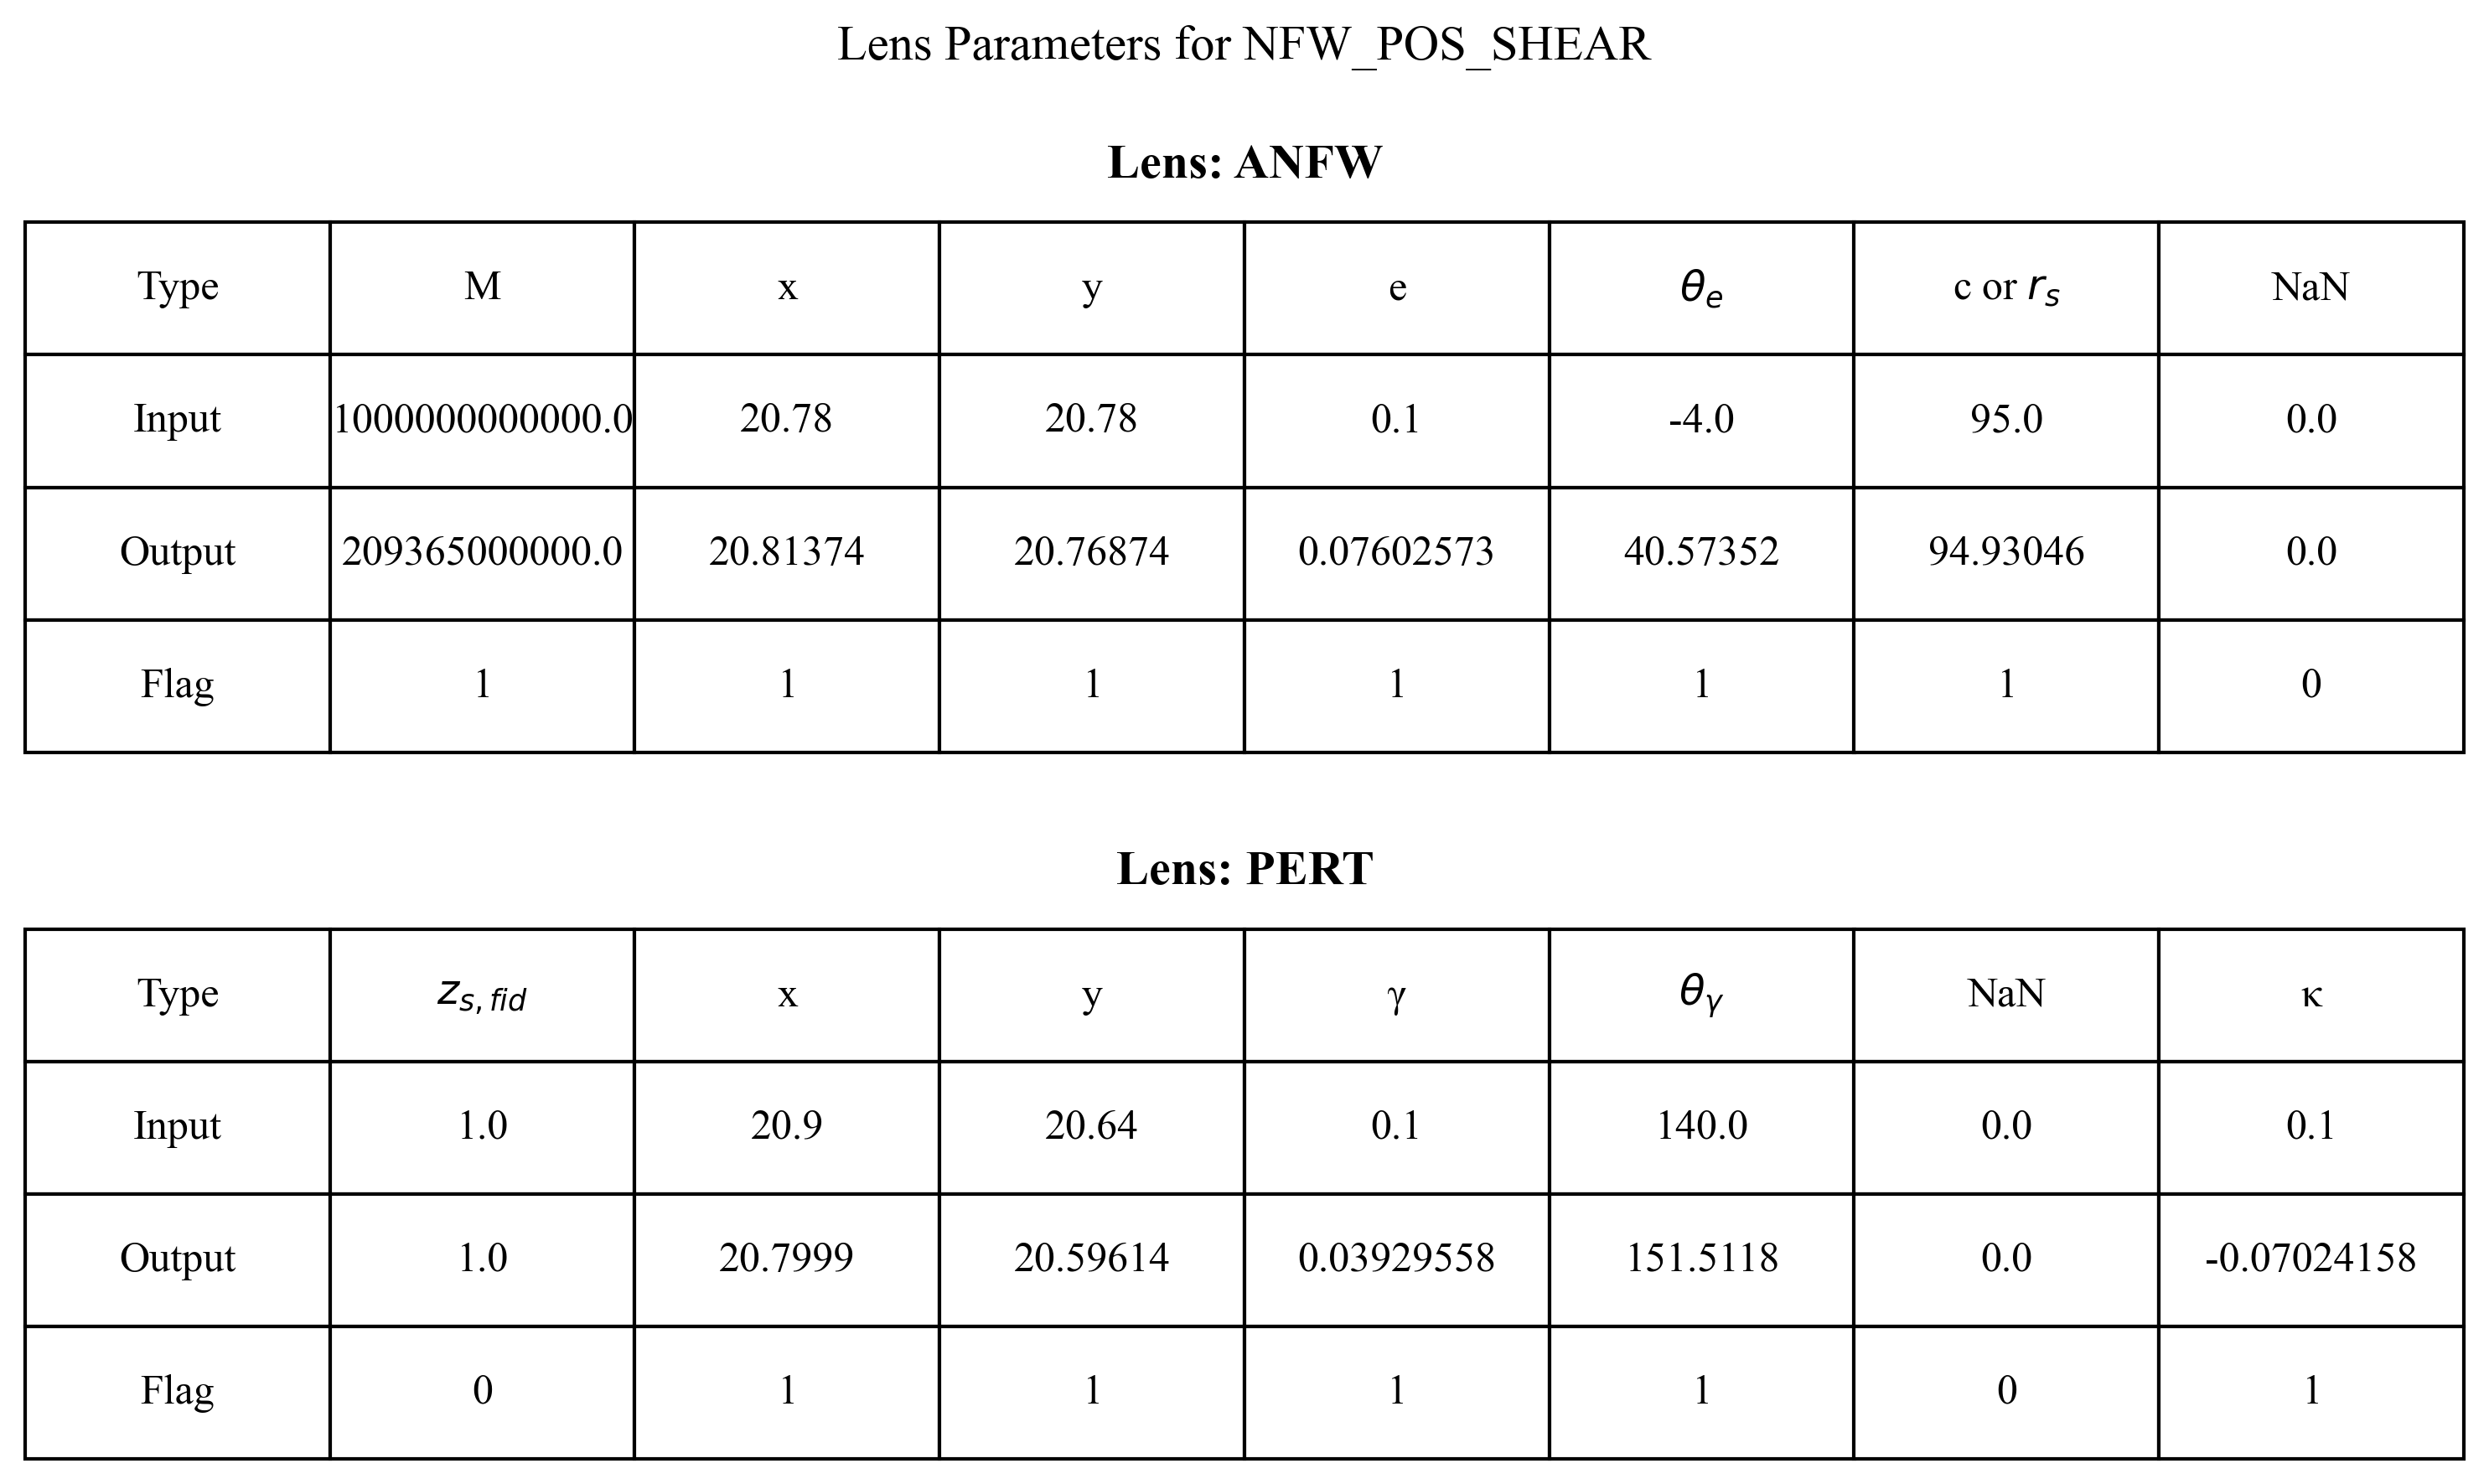

In [212]:
# Plot all lens parameter tables on the same figure, spaced vertically, without the first column (Lens Name)
fig, ax = plt.subplots(figsize=(10, 3 * len(dfs)))
ax.axis('off')

y_offset = 0.95  # Start at top
table_height = 0.45  # Height for each table
spacing = 0.15  # Space between tables
label_padding = 0.03  # Extra padding between label and table

for i, lens_df in enumerate(dfs):
    nrows = lens_df.shape[0]
    # Exclude the first column (Lens Name)
    table_data = lens_df.iloc[:, 1:].values
    col_labels = lens_df.columns[1:]
    # Calculate position for this table
    y_pos = y_offset - i * (table_height + spacing)
    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        bbox=[0, y_pos - table_height, 1, table_height]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2,1.2)
    # Add lens name as a label above each table, all uppercase, with extra padding
    lens_label = f"   Lens: {lens_df['Lens Name'][0].upper()}   "
    ax.text(0.5, y_pos + label_padding, lens_label, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title(f"Lens Parameters for {model_ver}", fontsize=14, pad=30)
plt.tight_layout()

In [213]:
# Anomaly Calculation
columnn_names = ['x', 'y', 'mag', 'pos_err', 'mag_err', '1', '2', '3']
obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
obs_point

,x,y,mag,pos_err,mag_err,1,2,3
0,20.77773,20.30254,4.27,0.00128,0.15,0.0,0.0,0
1,21.27308,20.95612,6.80,0.00085,0.14,0.0,0.0,0
2,20.39091,21.05057,5.98,0.00083,0.17,0.0,0.0,0
3,20.81981,21.25931,15.30,0.00039,0.16,0.0,0.0,0


In [214]:
out_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
out_point.drop(columns=['mag_err', '1', '2', '3'], inplace=True)

In [215]:
# Drop rows in obs_point where the corresponding out_point['mag'] < 1
mask = abs(out_point['mag']) >= 1
out_point = out_point[mask[:len(out_point)]].reset_index(drop=True)

out_point

,x,y,mag,pos_err
0,20.7777,20.3025,-11.3735,0.600
1,21.2731,20.9561,21.4404,0.000
2,20.3909,21.0506,23.6727,0.024
3,20.8198,21.2593,-33.3397,0.088


In [216]:
out_point['x_diff'] = abs(out_point['x'] - obs_point['x'])
out_point['y_diff'] = abs(out_point['y'] - obs_point['y'])
out_point['mag_diff'] = abs(out_point['mag']) - abs(obs_point['mag'])
out_point

,x,y,mag,pos_err,x_diff,y_diff,mag_diff
0,20.7777,20.3025,-11.3735,0.600,0.00003,0.00004,7.1035
1,21.2731,20.9561,21.4404,0.000,0.00002,0.00002,14.6404
2,20.3909,21.0506,23.6727,0.024,0.00001,0.00003,17.6927
3,20.8198,21.2593,-33.3397,0.088,0.00001,0.00001,18.0397


In [217]:
# RMS 
# Positions
pos_sum_sq = out_point['x_diff']**2 + out_point['y_diff']**2
pos_sq = np.sqrt(pos_sum_sq) # Plotted on graph
pos_rms = np.average(pos_sq)
print(f"RMS of the differences: {pos_rms:.6f}")
out_point['pos_sq'] = pos_sq

# Magnifications
mag_sum_sq = out_point['mag_diff']**2
mag_sq = np.sqrt(mag_sum_sq)
mag_rms = np.average(mag_sq)
print(f"RMS of the magnification differences: {mag_rms:.6f}")

RMS of the differences: 0.000031
RMS of the magnification differences: 14.369075


In [218]:
# Position Anomalies 
one_sigma_pos = obs_point['pos_err'] * 1.0

out_point['pos_anomaly'] = np.where(out_point['pos_sq'] > one_sigma_pos, 'Anomaly', 'Normal')
out_point

,x,y,mag,pos_err,x_diff,y_diff,mag_diff,pos_sq,pos_anomaly
0,20.7777,20.3025,-11.3735,0.600,0.00003,0.00004,7.1035,0.000050,Normal
1,21.2731,20.9561,21.4404,0.000,0.00002,0.00002,14.6404,0.000028,Normal
2,20.3909,21.0506,23.6727,0.024,0.00001,0.00003,17.6927,0.000032,Normal
3,20.8198,21.2593,-33.3397,0.088,0.00001,0.00001,18.0397,0.000014,Normal


In [219]:
# Magnification Anomalies
one_sigma_mag = obs_point['mag_err'] * 1.0

one_sigma_mag_up = obs_point['mag'] + one_sigma_mag
one_sigma_mag_down = obs_point['mag'] - one_sigma_mag

out_point['mag_anomaly'] = np.where(
    (abs(out_point['mag']) > one_sigma_mag_up) | (abs(out_point['mag']) < one_sigma_mag_down),
    'Anomaly',
    'Normal'
)
# Combine the anomalies into a single column

In [220]:
out_point['index'] = np.arange(len(out_point)) + 1
out_point


,x,y,mag,pos_err,x_diff,y_diff,mag_diff,pos_sq,pos_anomaly,mag_anomaly,index
0,20.7777,20.3025,-11.3735,0.600,0.00003,0.00004,7.1035,0.000050,Normal,Anomaly,1
1,21.2731,20.9561,21.4404,0.000,0.00002,0.00002,14.6404,0.000028,Normal,Anomaly,2
2,20.3909,21.0506,23.6727,0.024,0.00001,0.00003,17.6927,0.000032,Normal,Anomaly,3
3,20.8198,21.2593,-33.3397,0.088,0.00001,0.00001,18.0397,0.000014,Normal,Anomaly,4


In [221]:
out_point['pos_anom'] = abs(out_point['pos_sq'] - one_sigma_pos)
out_point['mag_anom'] = np.minimum(
    abs(out_point['mag_diff'] - one_sigma_mag_up),
    abs(out_point['mag_diff'] - one_sigma_mag_down)
)



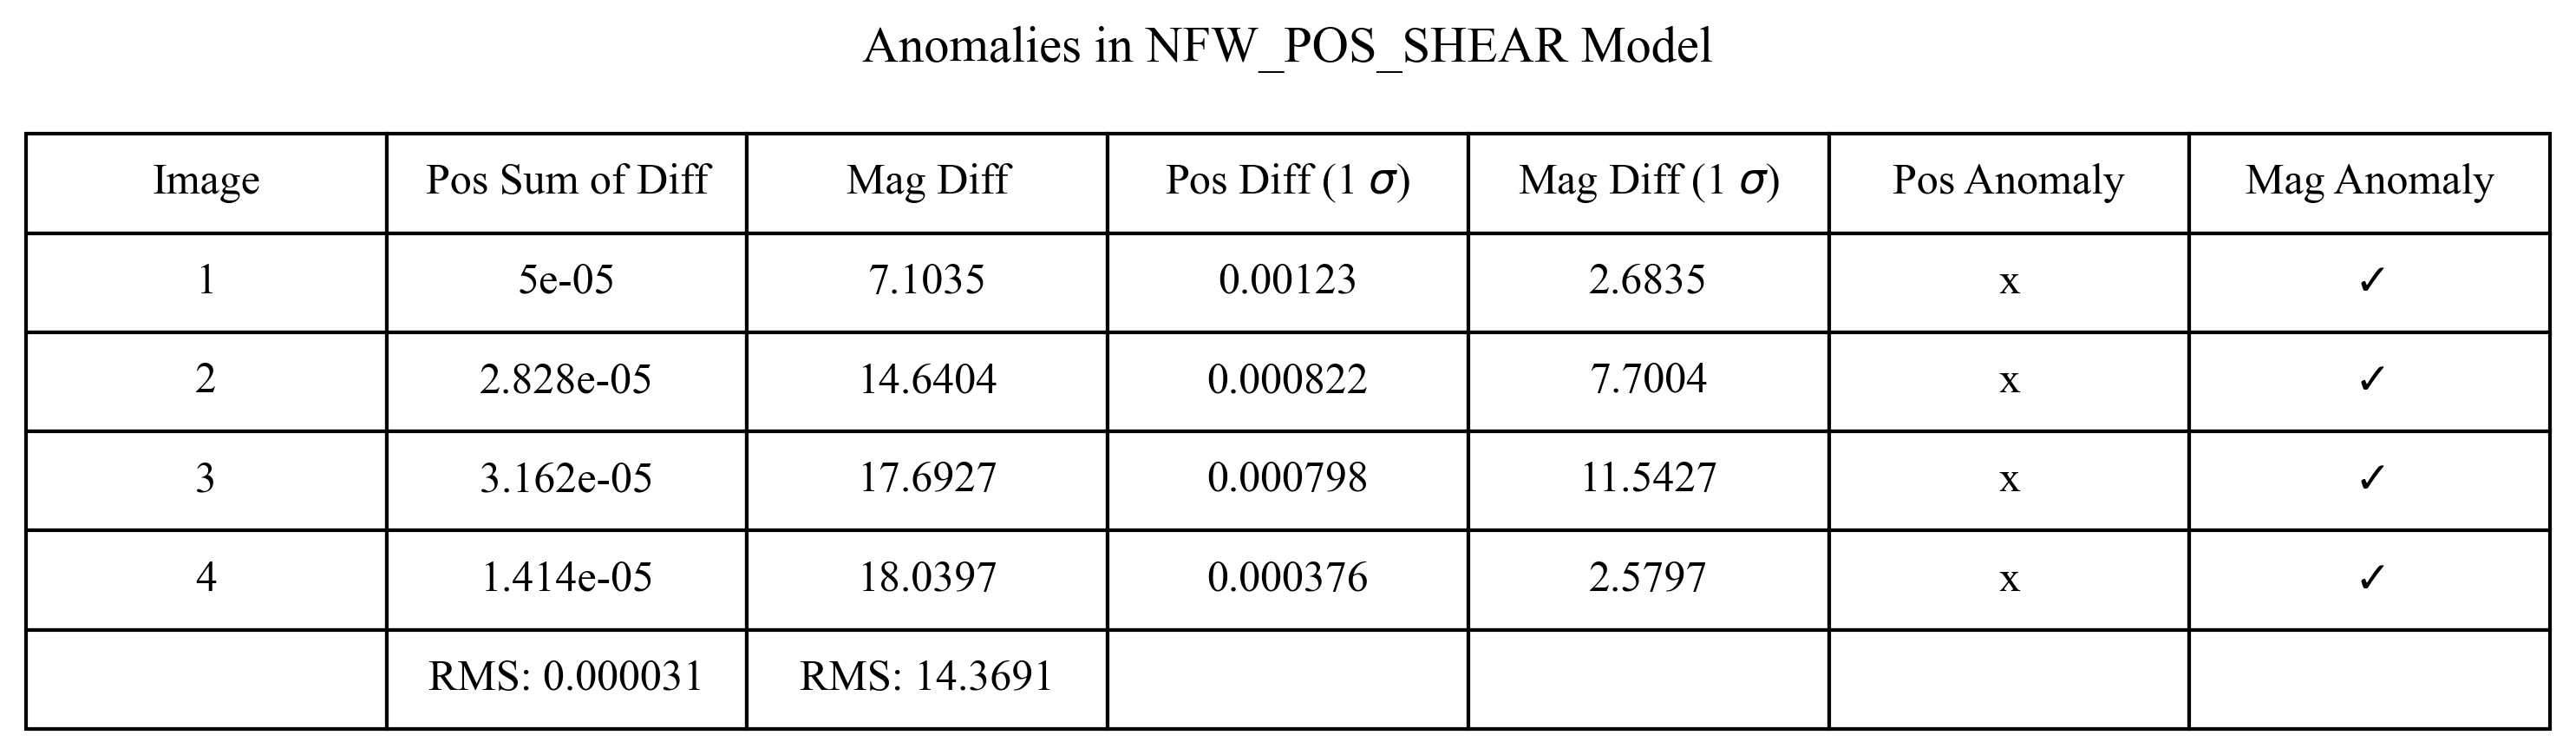

In [222]:
# Replace anomaly flags with ticks/crosses
def flag_to_symbol(flag):
    return '$\checkmark$' if flag == 'Anomaly' else 'x'

out_point['pos_sq'] = out_point['pos_sq'].round(8)
out_point['mag_diff'] = out_point['mag_diff'].round(4)
out_point['pos_anom'] = out_point['pos_anom'].round(6)
out_point['mag_anom'] = out_point['mag_anom'].round(4)

table_data = out_point[['index', 'pos_sq', 'mag_diff', 'pos_anom', 'mag_anom', 'pos_anomaly', 'mag_anomaly']].copy()
table_data['pos_anomaly'] = table_data['pos_anomaly'].apply(flag_to_symbol)
table_data['mag_anomaly'] = table_data['mag_anomaly'].apply(flag_to_symbol)

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

# Add RMS line at the end
rms_row = [
    '',  # index column
    f'RMS: {pos_rms:.6f}',
    f'RMS: {mag_rms:.4f}',
    '',  # pos_anomaly column
    '',   # mag_anomaly column
    '',
    ''
]
table_values = table_data.values.tolist() + [rms_row]
col_labels = ['Image', 'Pos Sum of Diff', 'Mag Diff', 'Pos Diff (1 $\sigma$)', 'Mag Diff (1 $\sigma$)', 'Pos Anomaly', 'Mag Anomaly']

table = ax.table(
    cellText=table_values,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title(f"Anomalies in {model_ver} Model", fontsize=14, pad=20)
plt.tight_layout()


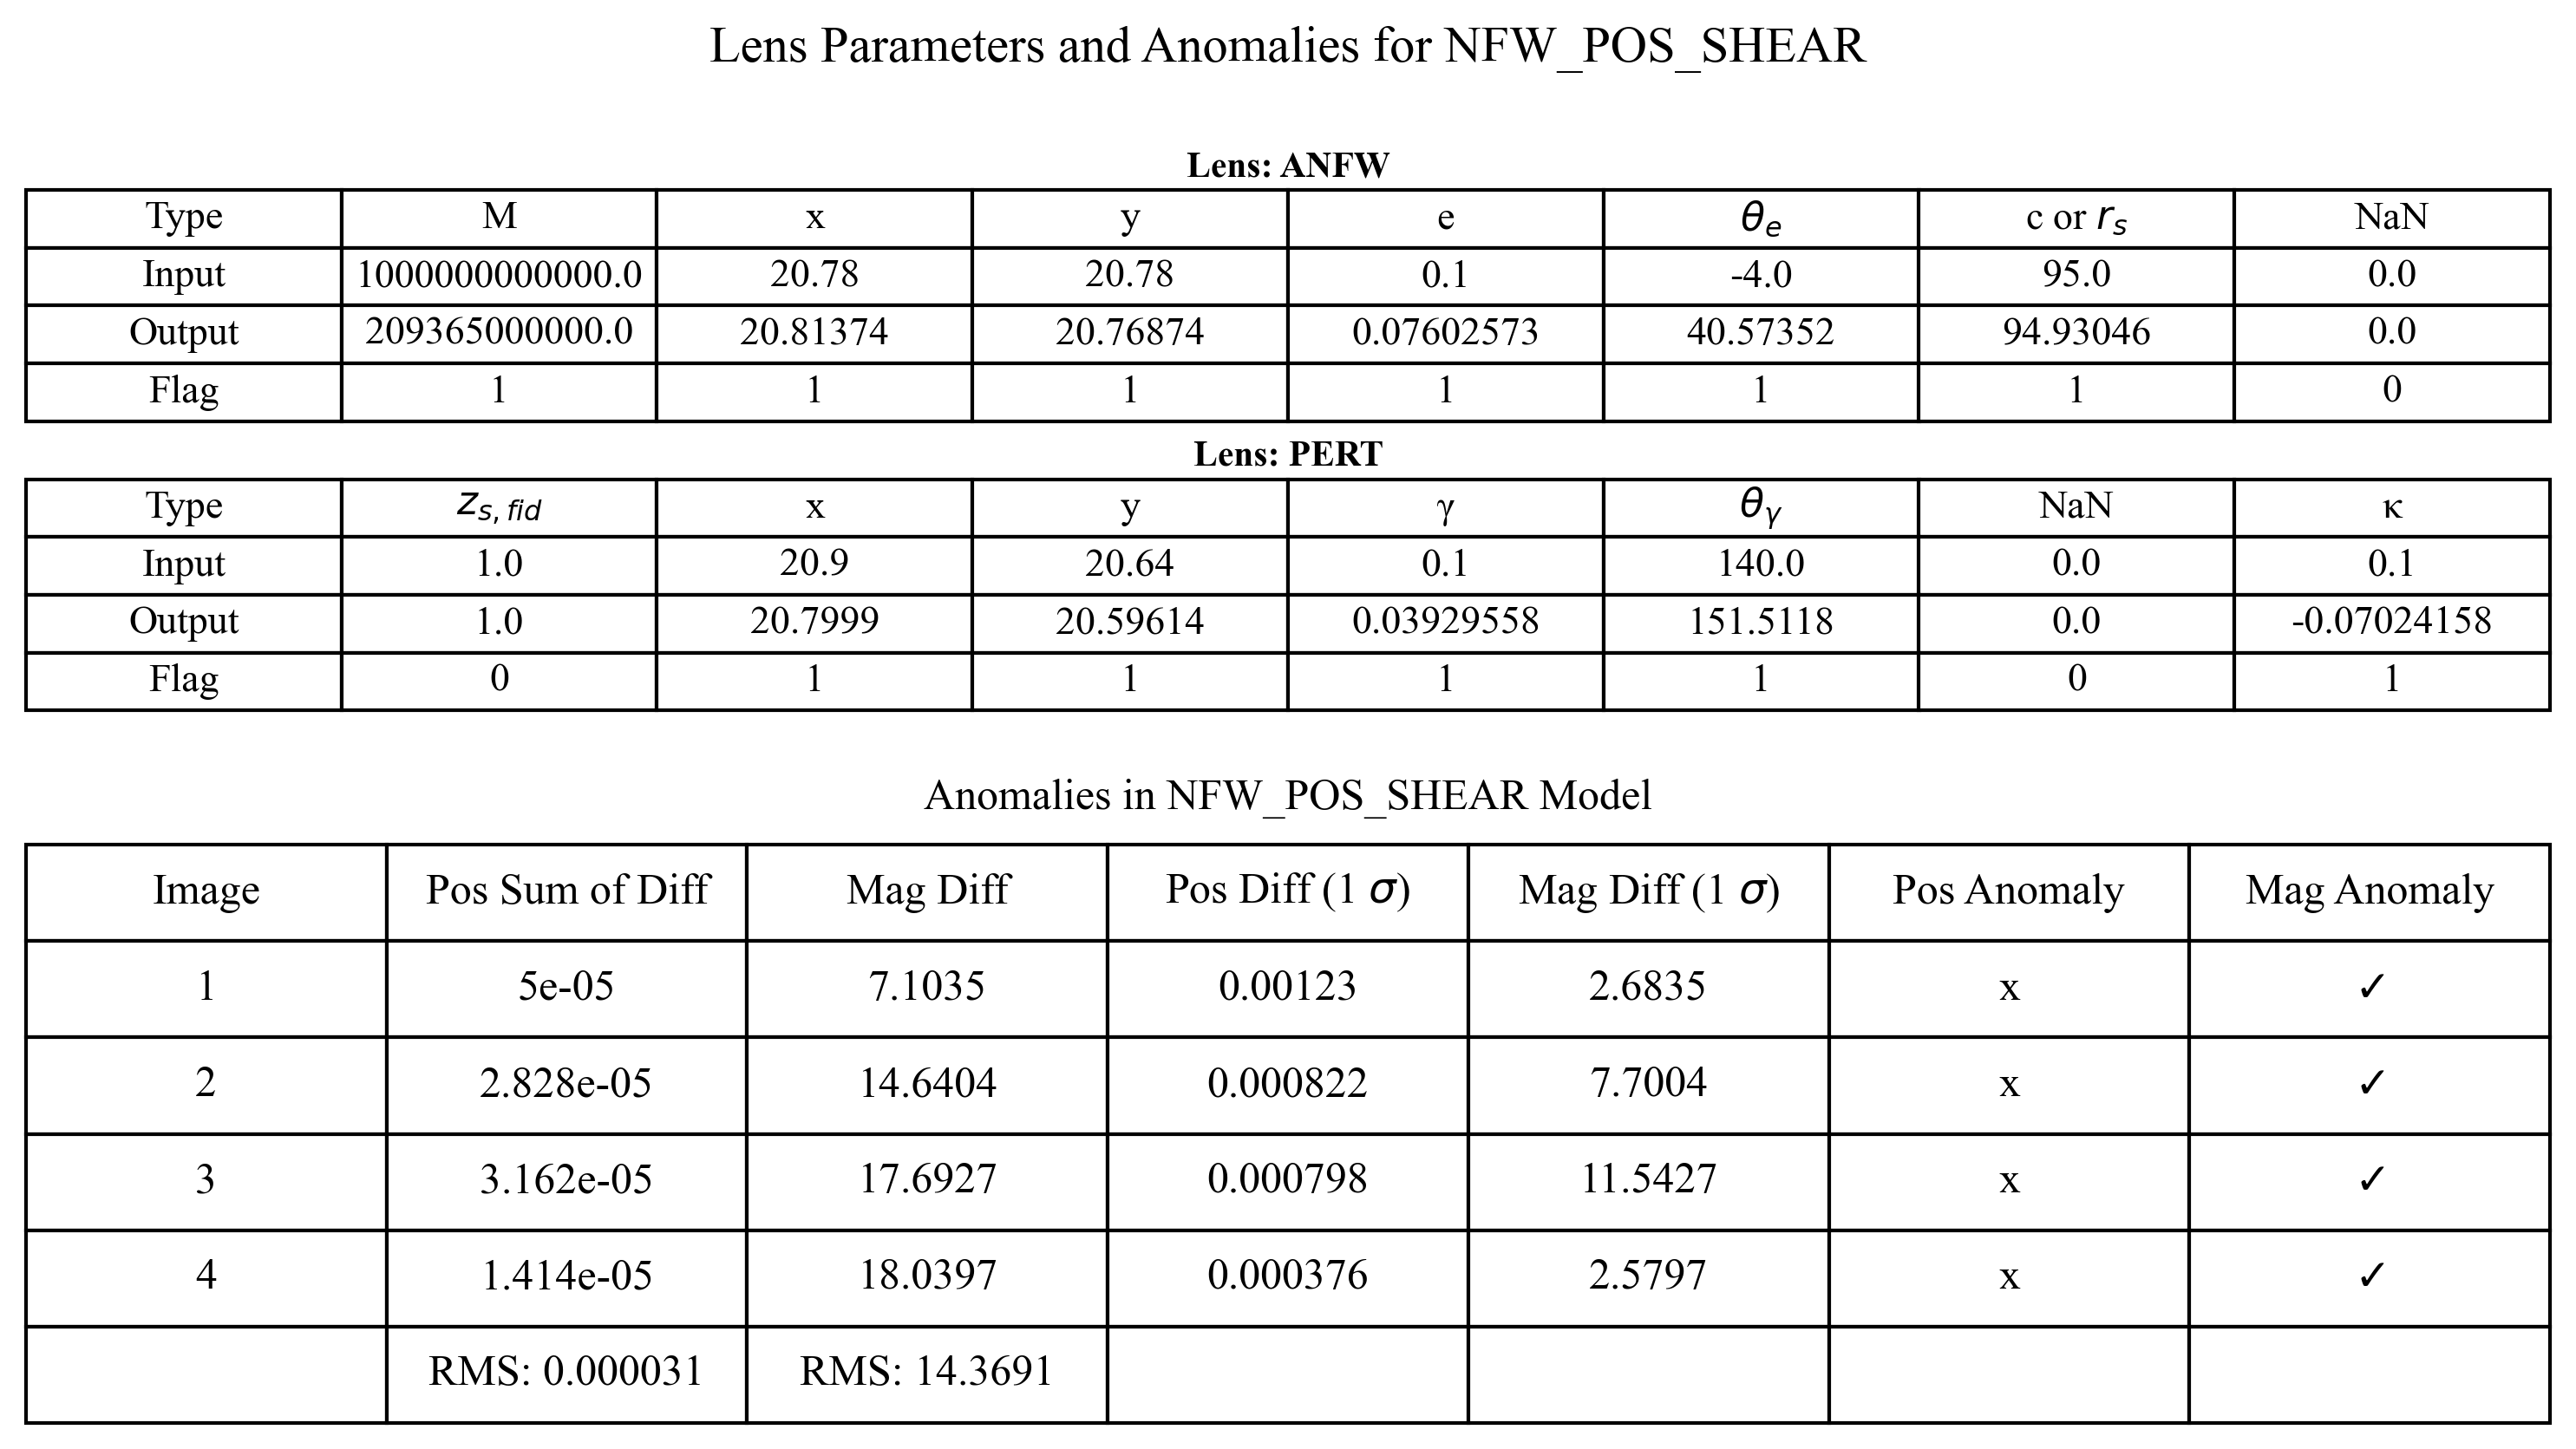

In [223]:
# Plot the two tables together
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})

# First table: Lens Parameters
ax1.axis('off')
y_offset = 0.95  # Start at top
row_height = 0.1  # adjust to control row spacing visually
spacing = 0.1     # space between tables

for i, lens_df in enumerate(dfs):
    nrows = lens_df.shape[0]
    table_height = row_height * (nrows + 1)  # +1 for header
    y_pos = y_offset - i * (table_height + spacing)

    table_data = lens_df.iloc[:, 1:].values
    col_labels_lens = lens_df.columns[1:]

    table = ax1.table(
        cellText=table_data,
        colLabels=col_labels_lens,
        cellLoc='center',
        loc='center',
        bbox=[0, y_pos - table_height, 1, table_height]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)

    lens_label = f"   Lens: {lens_df['Lens Name'][0].upper()}   "
    ax1.text(0.5, y_pos + 0.01, lens_label, ha='center', va='bottom',
             fontsize=10, fontweight='bold')


plt.suptitle(f"Lens Parameters and Anomalies for {model_ver}", fontsize=14, y=0.95)

# Second table: Anomalies
ax2.axis('off')
# Define column labels for the anomaly table
table = ax2.table(
    cellText=table_values,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title(f"Anomalies in {model_ver} Model", fontsize=12, pad=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title

plt.show()


In [226]:
# Define function to make both tables
def make_tables(model_ver, model_path, constraint):
    # Load the data
    with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
        opt_result = file.readlines()

    # Find the last line with 'optimize' in it
    last_optimize_index = None
    for idx in range(len(opt_result) - 1, -1, -1):
        if 'optimize' in opt_result[idx]:
            last_optimize_index = idx
            break
    if last_optimize_index is None:
        raise ValueError("No line with 'optimize' found in the file.")

    # Extract everything after the last 'optimize' line
    opt_result = opt_result[last_optimize_index + 1:]

    # Count the number of lines that start with 'lens'
    lens_count = sum(1 for line in opt_result if line.startswith('lens'))

    # Initialize a dictionary to hold the lens parameters
    lens_params_dict = {}

    # Extract the lens parameters
    lens_params = []
    for line in opt_result:
        if line.startswith('lens'):
            parts = re.split(r'\s+', line.strip())
            lens_name = parts[1]
            params = [float(x) for x in parts[2:]]

            # Store the parameters in the dictionary
            lens_params_dict[lens_name] = params
            lens_params.append((lens_name, params))

    # Remove the first lens parameter
    if lens_params:
        for i in range(len(lens_params)):
            lens_name, params = lens_params[i]
            lens_params_dict[lens_name] = params[1:]

    # Number of len profiles
    num_lens_profiles = len(lens_params_dict)

    # Use generic column names: param1, param2, ...
    df = pd.DataFrame()
    rows = []
    max_param_len = 0

    for lens_name, params in lens_params_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows.append(row)
        if len(params) > max_param_len:
            max_param_len = len(params)

    columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
    df = pd.DataFrame(rows
, columns=columns)
    
    # Load the input parameters from the Python file
    with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
        py = file.readlines()

    # Extracting the input parameters from the Python file
    set_lens_lines = [line for line in py if line.startswith('glafic.set_lens(')]
    if not set_lens_lines:
        raise ValueError("No lines starting with 'glafic.set_lens(' found in the file.")

    set_lens_params = []
    for line in set_lens_lines:
        match = re.search(r'set_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_lens_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")

    # Store the parameters in a dictionary
    set_lens_dict = {}
    for params in set_lens_params:
        if len(params) < 3:
            raise ValueError(f"Not enough parameters found in line: {params}")
        lens_name = params[1].strip("'\"")  # Remove quotes from lens name
        lens_params = [float(x) for x in params[2:]]  # Skip index and lens name
        set_lens_dict[lens_name] = lens_params

    # Remove the first lens parameter
    if set_lens_dict:
        for lens_name, params in set_lens_dict.items():
            set_lens_dict[lens_name] = params[1:]  # Remove the first parameter (index)

    # Use generic column names: param1, param2, ...
    df_input = pd.DataFrame()
    rows_input = []
    max_param_len_input = 0
    for lens_name, params in set_lens_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows_input.append(row)
        if len(params) > max_param_len_input:
            max_param_len_input = len(params)
    columns_input = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len_input)]
    df_input = pd.DataFrame(rows_input, columns=columns_input)
    
    # Extract input flags from the Python file
    set_flag_lines = [line for line in py if line.startswith('glafic.setopt_lens(')]
    if not set_flag_lines:
        raise ValueError("No lines starting with 'glafic.setopt_lens(' found in the file.")
    set_flag_params = []
    for line in set_flag_lines:
        match = re.search(r'setopt_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_flag_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")
    
    # Store the parameters in a dictionary
    set_flag_dict = {}
    for params in set_flag_params:
        if len(params) < 2:
            raise ValueError(f"Not enough parameters found in line: {params}")
        # The lens name is not present in setopt_lens, so use the lens index to map to set_lens_dict
        lens_index = params[0].strip("'\"")
        # Find the lens name corresponding to this index from set_lens_params
        lens_name = None
        for lens_params in set_lens_params:
            if lens_params[0].strip("'\"") == lens_index:
                lens_name = lens_params[1].strip("'\"")
                break
        if lens_name is None:
            raise ValueError(f"Lens name for index {lens_index} not found in set_lens_params")
        flag = ','.join(params[1:])  # Join all flag values as a string
        set_flag_dict[lens_name] = flag
   
    # Remove the first flag parameter
    if set_flag_dict:
        for lens_name, flag in set_flag_dict.items():
            flag_parts = flag.split(',')
            set_flag_dict[lens_name] = ','.join(flag_parts[1:])  # Remove the first flag parameter
    
    # Dynamically create columns: 'Lens Name', 'flag1', 'flag2', ..., based on the maximum number of flags
    df_flag = pd.DataFrame()
    rows_flag = []
    max_flag_len = 0
    
    # First, determine the maximum number of flags
    for flag in set_flag_dict.values():
        flag_parts = flag.split(',')
        if len(flag_parts) > max_flag_len:
            max_flag_len = len(flag_parts)
    for lens_name, flag in set_flag_dict.items():
        flag_parts = flag.split(',')
        row = {'Lens Name': lens_name}
        for i, val in enumerate(flag_parts):
            row[f'flag{i+1}'] = val
        rows_flag.append(row)
    columns_flag = ['Lens Name'] + [f'flag{i+1}' for i in range(max_flag_len)]  
    df_flag = pd.DataFrame(rows_flag, columns=columns_flag)
    
    # Combine all dataframes into a list of dataframes for each lens
    dfs = []
    
    for i in range(num_lens_profiles):
        lens_name = df['Lens Name'][i]
        
        # Find the model type (case-insensitive match)
        model_type = None
        for m in model_list:
            if m.lower() == lens_name.lower():
                model_type = m
                break
        if model_type is None:
            continue

        symbols = model_params[model_type][:7]
        # Row 2: input
        row_input = pd.DataFrame([df_input.iloc[i, 1:8].values], columns=symbols)
        # Row 3: output
        row_output = pd.DataFrame([df.iloc[i, 1:8].values], columns=symbols)
        # Row 4: flags
        row_flags = pd.DataFrame([df_flag.iloc[i, 1:8].values], columns=symbols)

        # Stack vertically, add a label column for row type
        lens_df = pd.concat([
            row_input.assign(Type='Input'),
            row_output.assign(Type='Output'),
            row_flags.assign(Type='Flag')
        ], ignore_index=True)
        lens_df.insert(0, 'Lens Name', lens_name)
        
        # Move 'Type' to the second column
        cols = lens_df.columns.tolist()
        cols.insert(1, cols.pop(cols.index('Type')))
        lens_df = lens_df[cols]
        dfs.append(lens_df)
    
    # Anomaly Calculation
    columnn_names = ['x', 'y', 'mag', 'pos_err', 'mag_err', '1', '2', '3']
    obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point.drop(columns=['mag_err', '1', '2', '3'], inplace=True)

    # Drop rows in obs_point where the corresponding out_point['mag'] < 1
    mask = abs(out_point['mag']) >= 1
    out_point = out_point[mask[:len(out_point)]].reset_index(drop=True)
    out_point['x_diff'] = abs(out_point['x'] - obs_point['x'])
    out_point['y_diff'] = abs(out_point['y'] - obs_point['y'])
    out_point['mag_diff'] = abs(out_point['mag']) - abs(obs_point['mag'])
    out_point['pos_sq'] = np.sqrt(out_point['x_diff']**2 + out_point['y_diff']**2)  # Plotted on graph

    # RMS
    pos_rms = np.average(out_point['pos_sq'])
    print(f"RMS of the differences: {pos_rms:.6f}")

    mag_rms = np.average(np.sqrt(out_point['mag_diff']**2))
    print(f"RMS of the magnification differences: {mag_rms:.6f}")

    # Position Anomalies
    one_sigma_pos = obs_point['pos_err'] * 1.0
    out_point['pos_anomaly'] = np.where(out_point['pos_sq'] > one_sigma_pos, 'Anomaly', 'Normal')
    
    # Magnification Anomalies
    one_sigma_mag = obs_point['mag_err'] * 1.0
    one_sigma_mag_up = obs_point['mag'] + one_sigma_mag
    one_sigma_mag_down = obs_point['mag'] - one_sigma_mag
    out_point['mag_anomaly'] = np.where(
        (abs(out_point['mag']) > one_sigma_mag_up) | (abs(out_point['mag']) < one_sigma_mag_down),
        'Anomaly',
        'Normal'
    )

    # Combine the anomalies into a single column
    out_point['index'] = np.arange(len(out_point)) + 1
    out_point['pos_anom'] = abs(out_point['pos_sq'] - one_sigma_pos)

    out_point['mag_anom'] = np.minimum(
        abs(out_point['mag_diff'] - one_sigma_mag_up),
        abs(out_point['mag_diff'] - one_sigma_mag_down)
    )
    # Replace anomaly flags with ticks/crosses
    def flag_to_symbol(flag):
        return '$\checkmark$' if flag == 'Anomaly' else 'x'
    out_point['pos_sq'] = out_point['pos_sq'].round(8)
    out_point['mag_diff'] = out_point['mag_diff'].round(4)
    out_point['pos_anom'] = out_point['pos_anom'].round(6)

    out_point['mag_anom'] = out_point['mag_anom'].round(4)
    table_data = out_point[['index', 'pos_sq', 'mag_diff', 'pos_anom', 'mag_anom', 'pos_anomaly', 'mag_anomaly']].copy()
    table_data['pos_anomaly'] = table_data['pos_anomaly'].apply(flag_to_symbol)
    table_data['mag_anomaly'] = table_data['mag_anomaly'].apply(flag_to_symbol)
    
    # Plot the two tables together
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
    
    # First table: Lens Parameters
    ax1.axis('off')
    y_offset = 0.95  # Start at top
    row_height = 0.1  # adjust to control row spacing visually
    spacing = 0.1     # space between tables

    for i, lens_df in enumerate(dfs):
        nrows = lens_df.shape[0]
        table_height = row_height * (nrows + 1)
        y_pos = y_offset - i * (table_height + spacing)
        table_data = lens_df.iloc[:, 1:].values
        col_labels_lens = lens_df.columns[1:]
        table = ax1.table(
            cellText=table_data,
            colLabels=col_labels_lens,
            cellLoc='center',
            loc='center',
            bbox=[0, y_pos - table_height, 1, table_height]
        )
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        lens_label = f"   Lens: {lens_df['Lens Name'][0].upper()}   "
        ax1.text(0.5, y_pos + 0.01, lens_label, ha='center', va='bottom',
                 fontsize=10, fontweight='bold')
    plt.suptitle(f"Lens Parameters and Anomalies for {model_ver}", fontsize=14, y=0.95)
    # Second table: Anomalies
    ax2.axis('off')
    # Define column labels for the anomaly table
    table = ax2.table(
        cellText=table_values,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title(f"Anomalies in {model_ver} Model", fontsize=12, pad=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()
    return dfs, out_point


RMS of the differences: 0.000031
RMS of the magnification differences: 14.369075


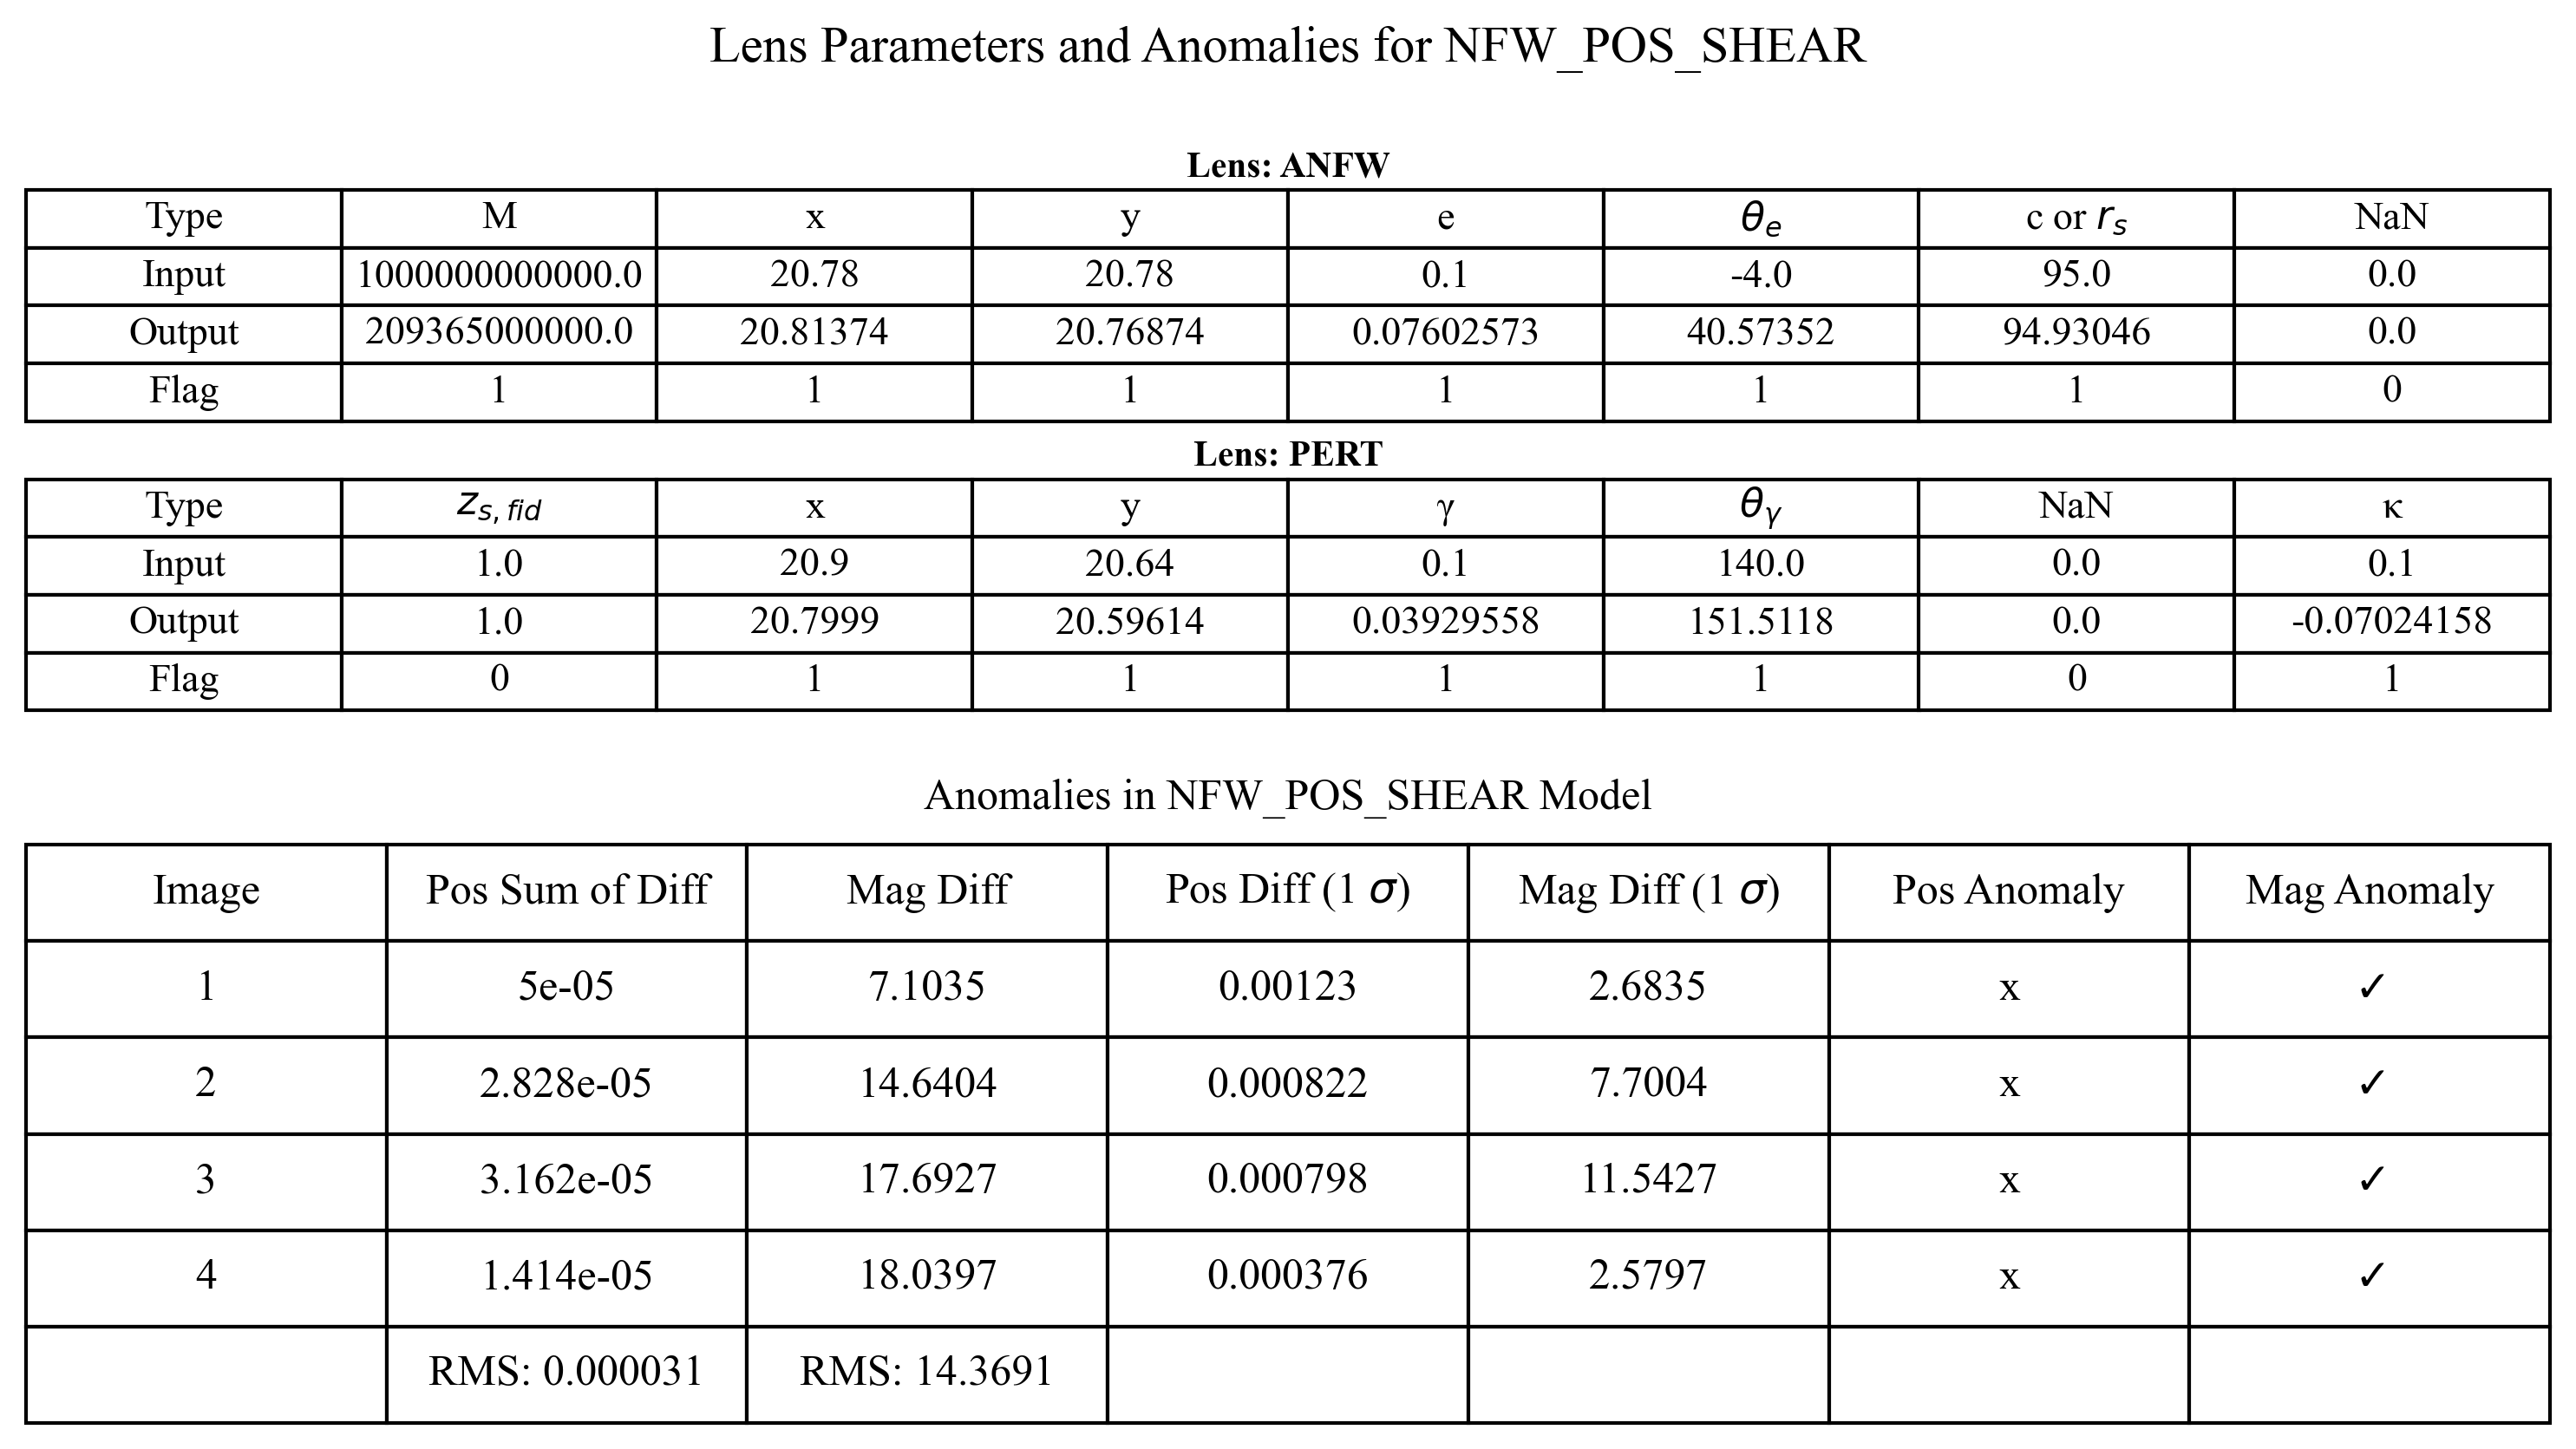

In [227]:
# Example usage
model_path = 'NFW+SHEAR'
model_ver = 'NFW_POS_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'

dfs, out_point = make_tables(model_ver, model_path, constraint)


RMS of the differences: 0.006038
RMS of the magnification differences: 5.775050


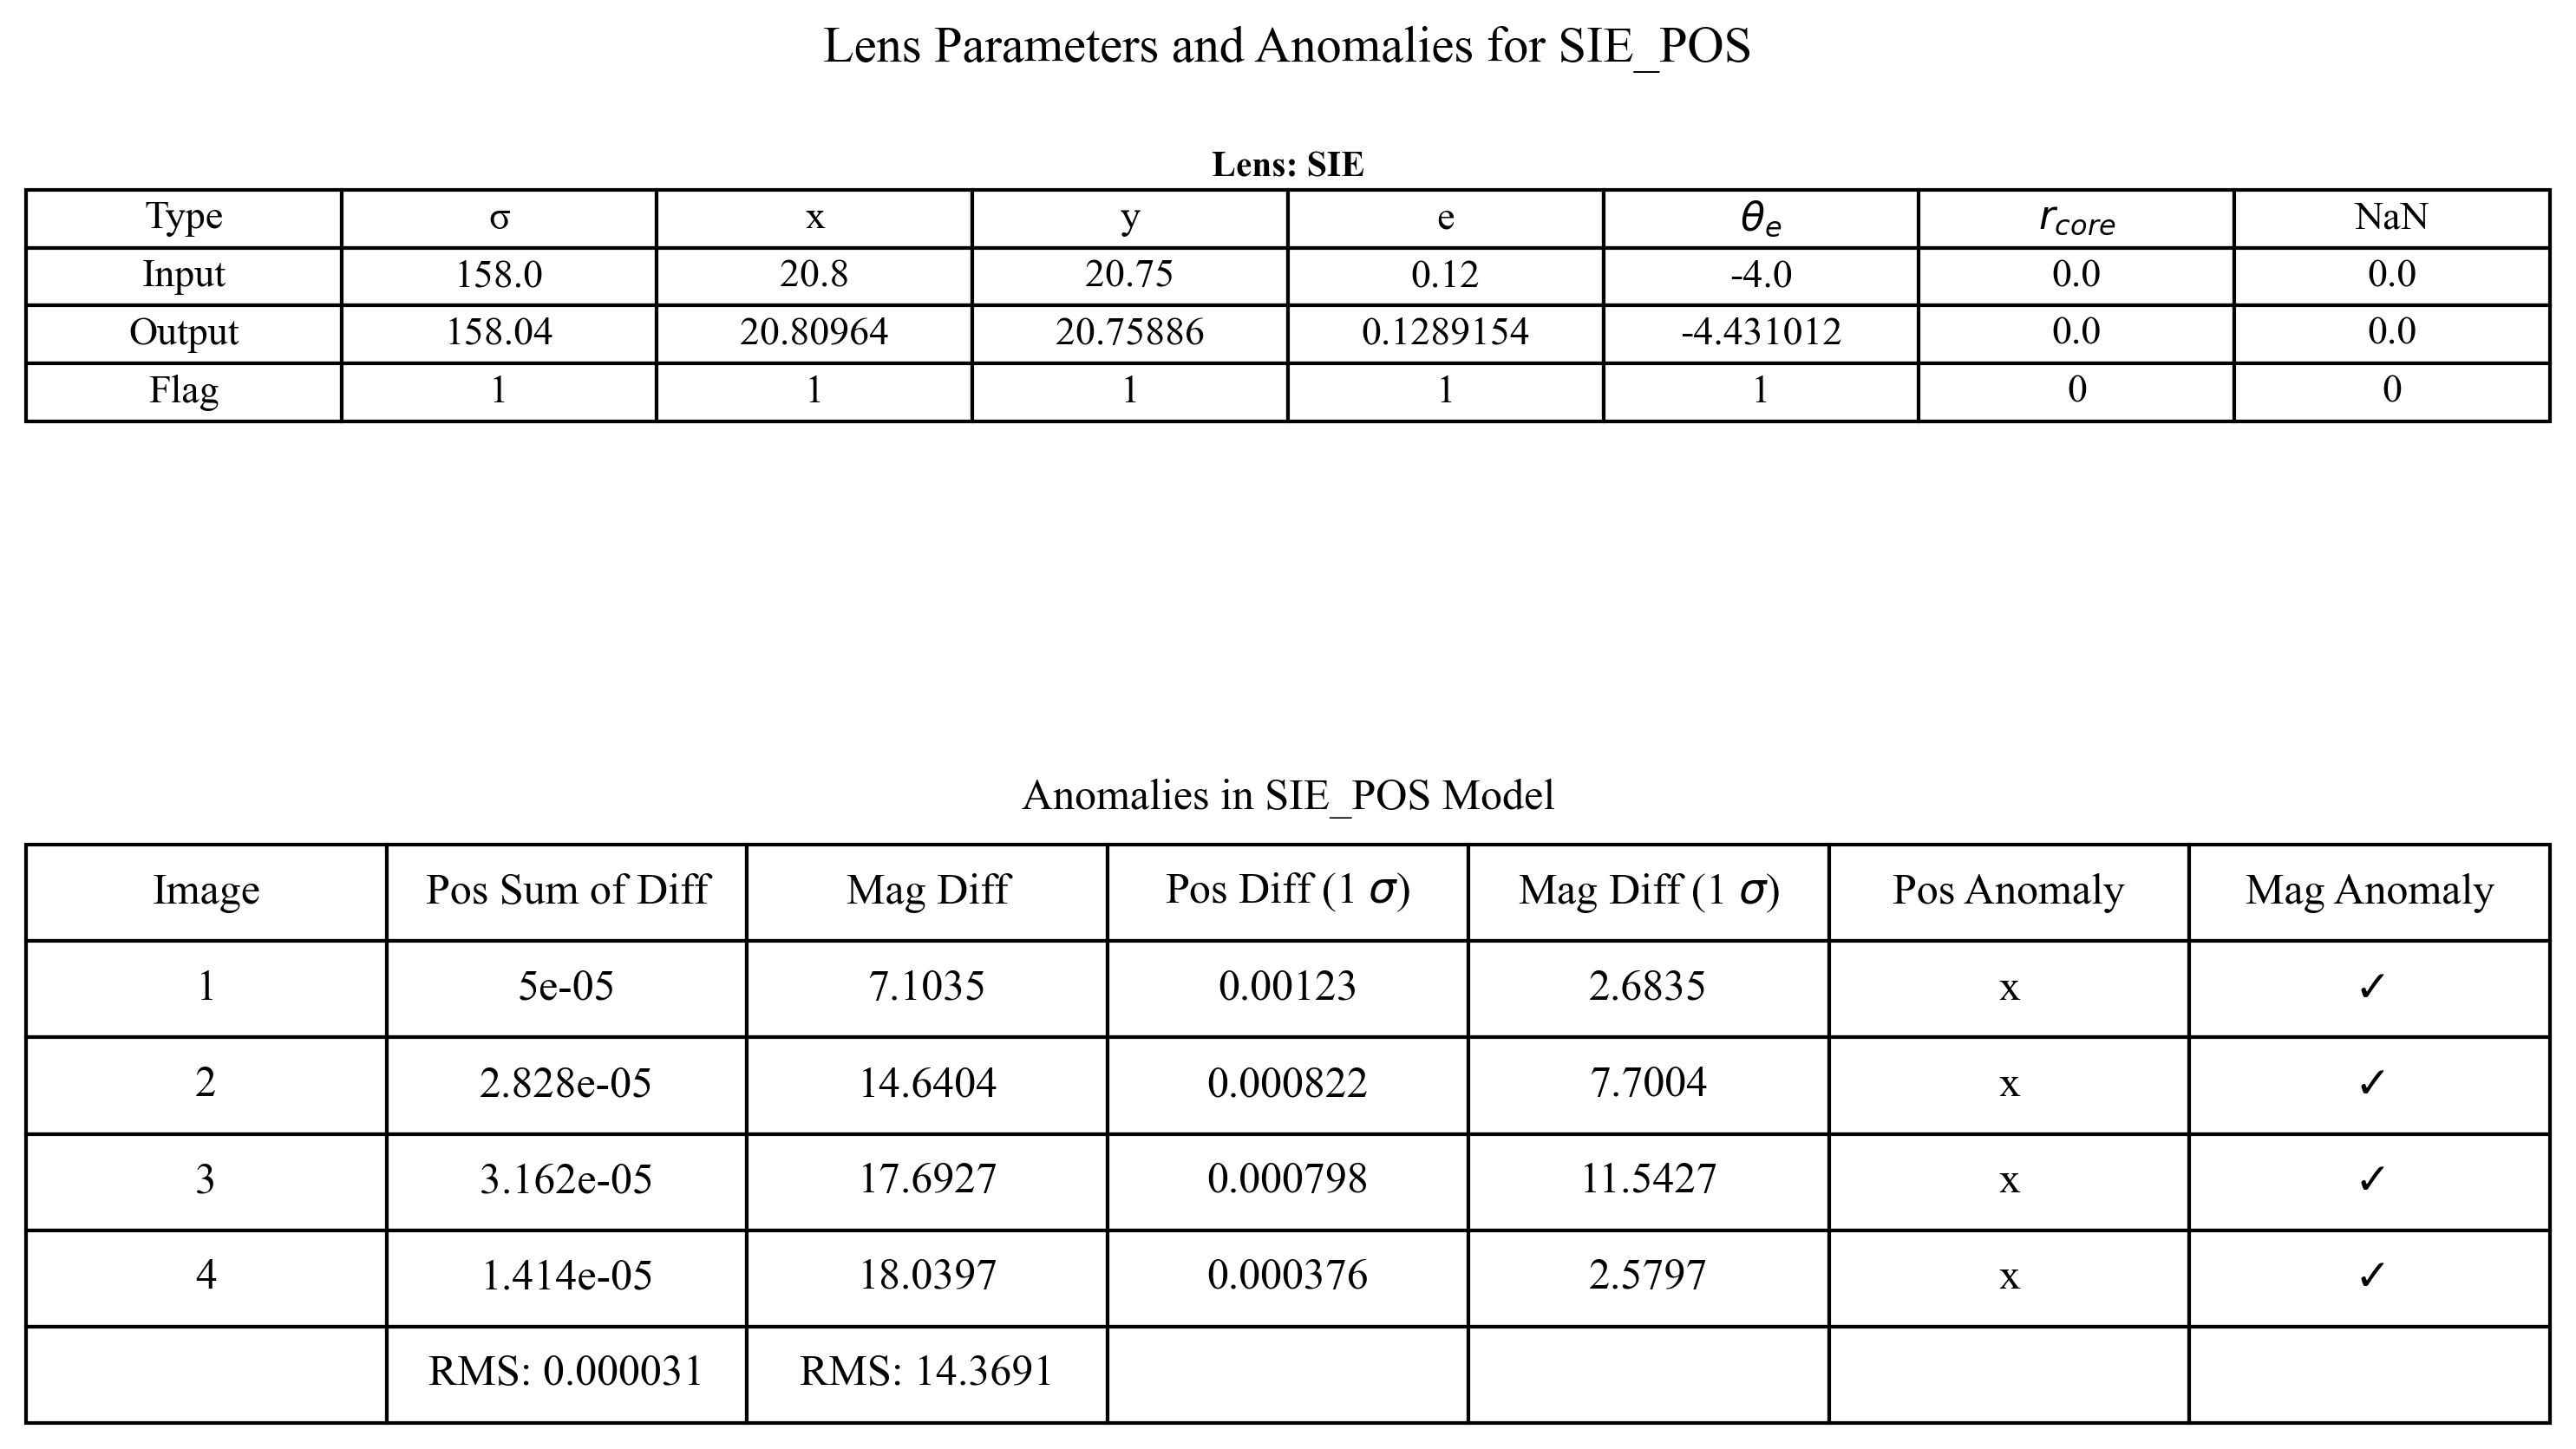

RMS of the differences: 0.006030
RMS of the magnification differences: 5.906900


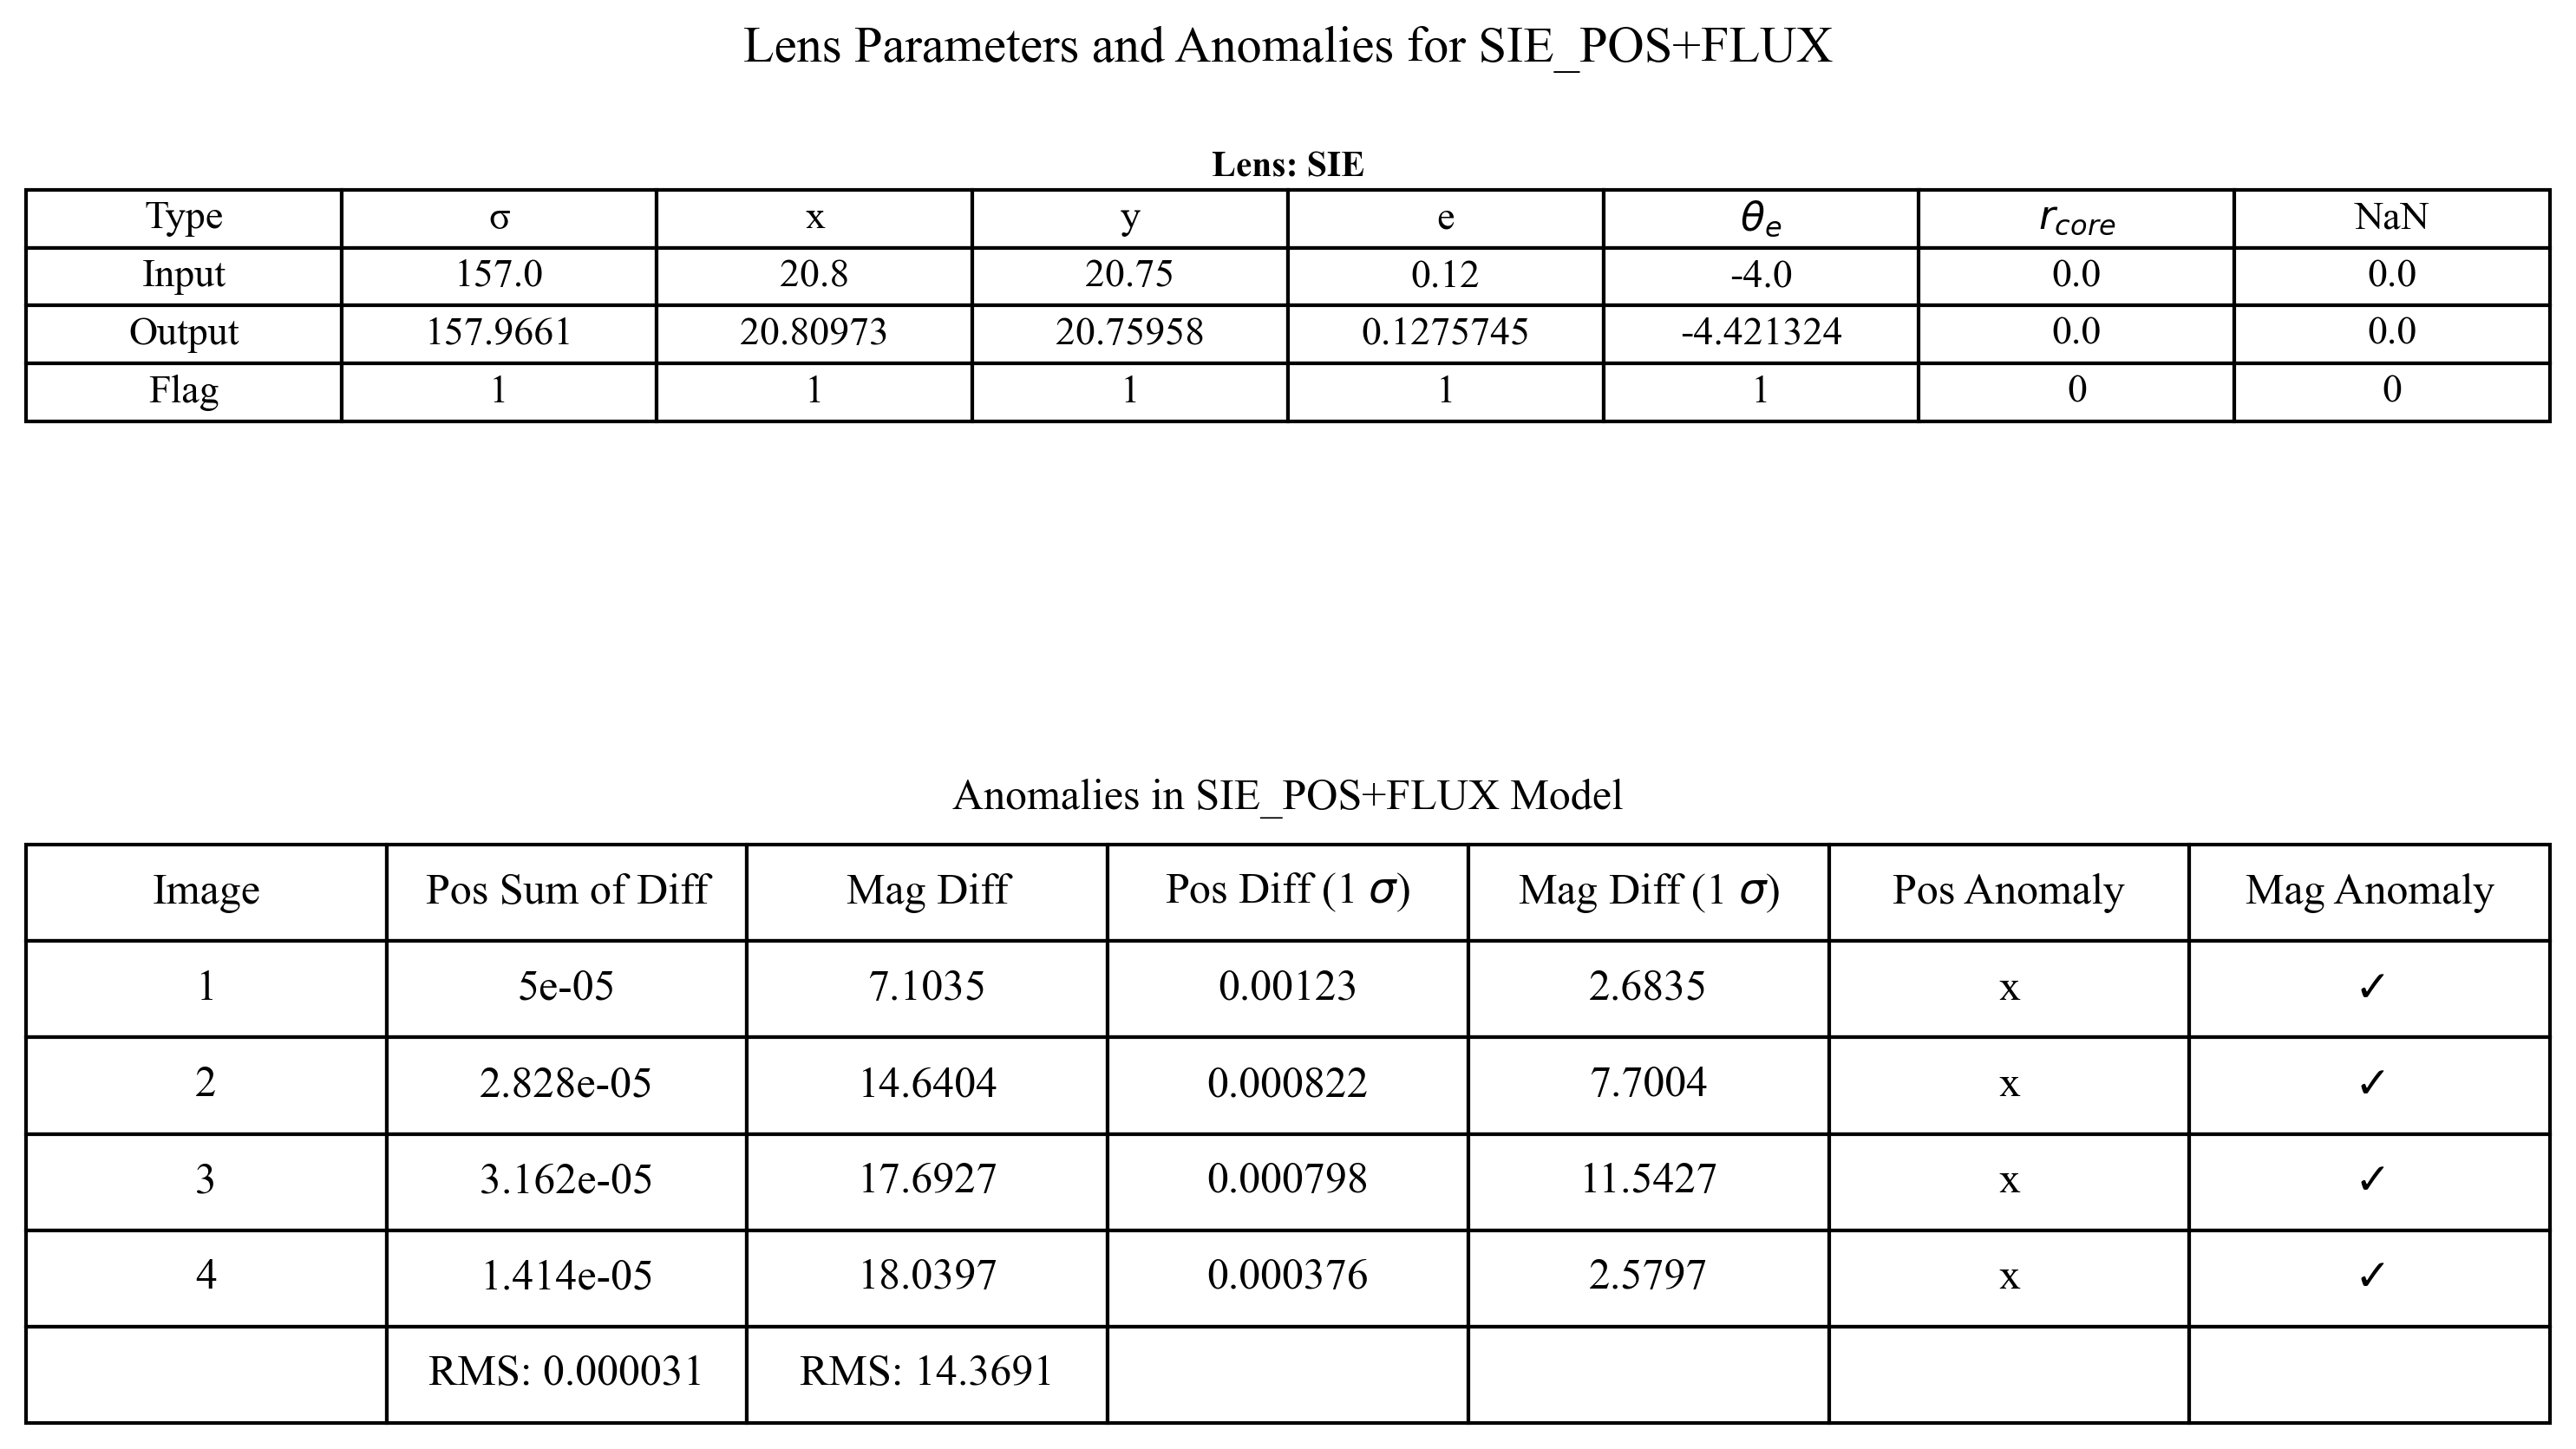

In [237]:
# Parse all models and save all tables 
# Create empty data frame to save tables as csv
all_tables = pd.DataFrame()

model_path_list = ['SIE']

for i in model_path_list:
    # Add 4 rows of blank space before each model
    all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)] * 4, columns=all_tables.columns)], ignore_index=True)

    if '+FIX' in i:
        i = i.replace('+FIX', '')
        
    if 'SHEAR' not in i:
        model_ver = i + '_POS'
        if 'Sersic' in i:
            j = i.replace('Sersic/', '')
            model_ver = j + '_POS'
        constraint = 'pos'
        dfs, out_point = make_tables(model_ver, i, constraint)
        all_tables = pd.concat([all_tables] + dfs, ignore_index=True)
        # Add out_point table
        out_point_str = out_point.astype(str)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)
        all_tables = pd.concat([all_tables, out_point_str], ignore_index=True)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)

        model_ver = i + '_POS+FLUX'
        if 'Sersic' in i:
            j = i.replace('Sersic/', '')
            model_ver = j + '_POS+FLUX'
        constraint = 'pos_flux'
        dfs, out_point = make_tables(model_ver, i, constraint)
        all_tables = pd.concat([all_tables] + dfs, ignore_index=True)
        out_point_str = out_point.astype(str)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)
        all_tables = pd.concat([all_tables, out_point_str], ignore_index=True)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)
    else:
        j = i.replace('+SHEAR', '')
        model_ver = j + '_POS_SHEAR'
        if 'Sersic' in i:
            j = i.replace('Sersic/', '')
            j = j.replace('+SHEAR', '')
            model_ver = j + '_POS_SHEAR'
        constraint = 'pos'
        dfs, out_point = make_tables(model_ver, i, constraint)
        all_tables = pd.concat([all_tables] + dfs, ignore_index=True)
        out_point_str = out_point.astype(str)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)
        all_tables = pd.concat([all_tables, out_point_str], ignore_index=True)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)

        model_ver = j + '_POS+FLUX_SHEAR'
        if 'Sersic' in i:
            j = i.replace('Sersic/', '')
            j = j.replace('+SHEAR', '')
            model_ver = j + '_POS+FLUX_SHEAR'
        constraint = 'pos_flux'
        dfs, out_point = make_tables(model_ver, i, constraint)
        all_tables = pd.concat([all_tables] + dfs, ignore_index=True)
        out_point_str = out_point.astype(str)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)
        all_tables = pd.concat([all_tables, out_point_str], ignore_index=True)
        all_tables = pd.concat([all_tables, pd.DataFrame([[''] * len(all_tables.columns)], columns=all_tables.columns)], ignore_index=True)

# Save the combined tables to a CSV file
all_tables.to_csv('all_lens_tables.csv', index=False)
